In [1]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from scipy.stats import linregress
import nibabel as nib
import urllib
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

### Read in the phenotypic behavioural data

This is the **Phenotypic_V1_0b_preprocessed1.csv** file.

You can find the explanations of all the columns in the **ABIDE_LEGEND_V1.02.pdf** file.

We're going to load the data into a pandas data frame.

In [2]:
behav_data_f = '../Phenotypic_V1_0b_preprocessed1.csv'
df = pd.read_csv(behav_data_f)

Our measure of interest is **func_perc_fd** so lets get rid of all participants who don't have a value!

We also want to make sure our data **has the data** so lets get rid of all participants who's file ID is "no_filename".

We also want to know the **age in years** for each participant.

In [3]:
df = df.loc[df['func_perc_fd'].notnull(), :]
df = df.loc[df['FILE_ID']!='no_filename', :]
df['AGE_YRS'] = np.floor(df['AGE_AT_SCAN'])

### Create a stratified sample

We want to see how similar the average connectivity values are ***when there are no differences between the groups***.

Therefore we need to split participants into ***matched*** samples.

What do they need to be matched on?!

* DSM_IV_TR -- their diagnosis according to the DSM IV (0: control, 1: ASD, 2: Asp, 3: PDD)
* SITE_ID -- the scanning site
* AGE_YRS -- age in years
* SEX -- sex (1: male, 2: female)


### Threshold your sample according to the motion/age cut offs

We're going to systematically change the upper threshold of the percent of volumes that exceed 0.2mm frame to frame dispacement.

And we're also going to select our lower and upper age limits. NOTE that these are inclusive boundaries. So for example a lower limit of 6 and an upper limit of 10 will include participants who are 6, 7, 8, 9 and 10 years old.

* func_perc_fd
* AGE_YRS

In [4]:
motion_thresh = 20
df_samp_motion = df.loc[df['func_perc_fd']<motion_thresh, :]

In [5]:
age_l, age_u = 6, 10
df_samp = df_samp_motion.loc[(df_samp_motion['AGE_YRS']>=age_l) & (df_samp_motion['AGE_YRS']<=age_u), :]

### Only keep 2n participants

Where n is the number of participants you're going to put in each group.

Remember to shuffle before you do this so you don't keep the top n participant every time.

In [6]:
n = 10000
n_2 = 2*n

df_samp_rand = df_samp.reindex(np.random.permutation(df_samp.index))
df_samp_2n = df_samp_rand.iloc[:2*n, :]

### Sort according to the matching measures

In [7]:
sort_column_list = ['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_YRS']
df_samp_2n_sorted = df_samp_2n.sort_values(by=sort_column_list)

### Split this data frame into two and VOILA

In [8]:
df_grp_A = df_samp_2n_sorted.iloc[::2, :]
df_grp_B = df_samp_2n_sorted.iloc[1::2, :]

### Actually this can be implemented as a function

The inputs to `split_two_matched_samples` are the master data frame (`df`), the motion threshold (`motion_thresh`), lower age limit (`age_l`), upper age limit (`age_u`) and the number of participants (`n`) in each group.

In [9]:
from split_two_matched_samples import split_two_matched_samples

df_A, df_B = split_two_matched_samples(df, 20, 6, 10, 50)

print df_A[['AGE_AT_SCAN', 'DX_GROUP', 'SEX']].describe()
print df_B[['AGE_AT_SCAN', 'DX_GROUP', 'SEX']].describe()


       AGE_AT_SCAN   DX_GROUP        SEX
count    50.000000  50.000000  50.000000
mean      9.333058   1.540000   1.180000
std       1.058688   0.503457   0.388088
min       7.228000   1.000000   1.000000
25%       8.512500   1.000000   1.000000
50%       9.510100   2.000000   1.000000
75%      10.215000   2.000000   1.000000
max      10.900000   2.000000   2.000000
       AGE_AT_SCAN   DX_GROUP        SEX
count    50.000000  50.000000  50.000000
mean      9.354656   1.540000   1.260000
std       1.144859   0.503457   0.443087
min       6.470000   1.000000   1.000000
25%       8.565100   1.000000   1.000000
50%       9.700000   2.000000   1.000000
75%      10.227950   2.000000   1.750000
max      10.990000   2.000000   2.000000


# Gettin the data

In [10]:
for f_id in df.loc[:, 'FILE_ID']:
    
    if not (f_id == "no_filename") and not os.path.isfile("../DATA/{}_rois_aal.1D".format(f_id)):
        print f_id
        testfile = urllib.URLopener()
    
        testfile.retrieve(("https://s3.amazonaws.com/fcp-indi/data/Projects"
                           "/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_aal"
                           "/{}_rois_aal.1D".format(f_id)), 
                              "../DATA/{}_rois_aal.1D".format(f_id))


# How similar are the matrices?

In [11]:
df_A, df_B = split_two_matched_samples(df, 20, 6, 10, 50)

In [12]:
ts_df = pd.read_table('../DATA/{}_rois_aal.1D'.format(f_id))

corr_mat = ts_df.corr()

corr_mat.shape
av_corr_mat = np.zeros([corr_mat.shape[0], corr_mat.shape[1], len(df_A)])

In [13]:

def make_group_corr_mat(df):
    
    for i, (sub, f_id) in enumerate(df[['SUB_ID', 'FILE_ID']].values):
        ts_df = pd.read_table('../DATA/{}_rois_aal.1D'.format(f_id))

        #print ts_df.isnull().sum().sum()
        corr_mat = ts_df.corr()
        
        if i == 0:
            all_corr_mat = np.zeros([corr_mat.shape[0], corr_mat.shape[1], len(df)])

        all_corr_mat[:, :, i] = corr_mat
        
    av_corr_mat = np.nanmean(all_corr_mat, axis=2)
    var_corr_mat = np.nanvar(all_corr_mat, axis=2)
        
    return all_corr_mat, av_corr_mat, var_corr_mat

    
    

In [14]:
all_corr_mat_A, av_corr_mat_A, var_corr_mat_A = make_group_corr_mat(df_A)
all_corr_mat_B, av_corr_mat_B, var_corr_mat_B = make_group_corr_mat(df_B)


In [15]:
diff_av_corr_mat = av_corr_mat_B - av_corr_mat_A

#np.argwhere(diff_av_corr_mat==0)

#exactly_zero_mat = np.copy(diff_av_corr_mat)
#exactly_zero_mat[(exactly_zero_mat<>0)] = 1
#exactly_zero_mat[np.diagonal(exactly_zero_mat)] = 1


#plt.imshow(exactly_zero_mat, cmap='RdBu_r', vmin=-0.1, vmax=0.1, interpolation='none')

In [16]:
print 116*116
print 116*115/2

x.shape


13456
6670


NameError: name 'x' is not defined

In [17]:
def calc_avg_sum_sqrs(av_corr_mat_A, av_corr_mat_B):
    inds = np.triu_indices_from(av_corr_mat_B, k=1)
    x = av_corr_mat_A[inds]
    y = av_corr_mat_B[inds]
    res = y - x
    res_sq = res**2
    av_sum_sqrs = np.sum(res_sq)/len(x)
    return av_sum_sqrs
    

In [191]:
n_perms = 100
av_sum_sqrs_list = []
for i in range(n_perms):
    df_A, df_B = split_two_matched_samples(df, 20, 6, 10, 50)
    all_corr_mat_A, av_corr_mat_A, var_corr_mat_A = make_group_corr_mat(df_A)
    all_corr_mat_B, av_corr_mat_B, var_corr_mat_B = make_group_corr_mat(df_B)

    av_sum_sqrs=calc_avg_sum_sqrs(av_corr_mat_A, av_corr_mat_B)
    
    av_sum_sqrs_list += [av_sum_sqrs]

print av_sum_sqrs_list

[0.0013578979437845081, 0.0014625832753645909, 0.00092194785539355438, 0.0017532712147499358, 0.0011883926006673194, 0.0012488665243224793, 0.0032910538921013771, 0.0010153601270472975, 0.0012926154671077294, 0.0012549704529044108, 0.0011903343543290771, 0.0011337201179879945, 0.0015784091768290527, 0.0026593769593641868, 0.0010823666875014492, 0.0012051015619456969, 0.0016879325583698921, 0.0012840091448549612, 0.0011541388077650626, 0.001029595005996664, 0.001258612856475704, 0.0014871827790309462, 0.0015094323073863839, 0.0012310450141629079, 0.0012320418268655325, 0.0016449231734521088, 0.0018200537415194059, 0.0029760249572654105, 0.0022011208437677618, 0.0013370332004954179, 0.00164486081616342, 0.0011101888074468436, 0.0011519872109799433, 0.0010521788961756814, 0.0011985255426830714, 0.0013094958630996325, 0.00097447399719468913, 0.0012027977818845155, 0.001116473416439144, 0.0022963329906307145, 0.0017679452470798739, 0.0011699080683840507, 0.0036457871533657742, 0.00107202642

In [18]:
def split_half_outcome(df, motion_thesh, age_l, age_u, n, n_perms=100):
    
    av_sum_sqrs_list = []
    for i in range(n_perms):
        df_A, df_B = split_two_matched_samples(df, motion_thresh, age_l, age_u, n)
        all_corr_mat_A, av_corr_mat_A, var_corr_mat_A = make_group_corr_mat(df_A)
        all_corr_mat_B, av_corr_mat_B, var_corr_mat_B = make_group_corr_mat(df_B)

        av_sum_sqrs=calc_avg_sum_sqrs(av_corr_mat_A, av_corr_mat_B)

        av_sum_sqrs_list += [av_sum_sqrs]
    
    return np.array(av_sum_sqrs_list)


In [ ]:
results_dict = {}

In [ ]:
age_l = 6
age_u = 20
n = 200

n_perms = 5
for motion_thresh in range(5, 71, 5):
    print motion_thresh
    
    key = (motion_thresh, age_l, age_u, n)
    value = split_half_outcome(df, motion_thresh, age_l, age_u, n, n_perms=n_perms)
    
    results_dict[key] = value
    

5
10
15
20
25
30
35
40
45
50
55


In [35]:
results_dict.keys()

[(35, 6, 20, 20),
 (20, 6, 20, 20),
 (45, 6, 20, 20),
 (30, 6, 20, 20),
 (55, 6, 20, 20),
 (5, 6, 20, 20),
 (65, 6, 20, 20),
 (50, 6, 20, 20),
 (15, 6, 20, 20),
 (60, 6, 20, 20),
 (25, 6, 20, 20),
 (10, 6, 20, 20),
 (40, 6, 20, 20),
 (70, 6, 20, 20)]

35 0.00311831461031
20 0.0027822700414
45 0.00358556389688
30 0.00410213150444
55 0.00554687041306
5 0.00380141914157
65 0.00355046432103
50 0.00363010134158
15 0.00293455029077
60 0.00350068486981
25 0.00396115280029
10 0.0038785466106
40 0.00396146946368
70 0.00326079785754


(0, 0.006)

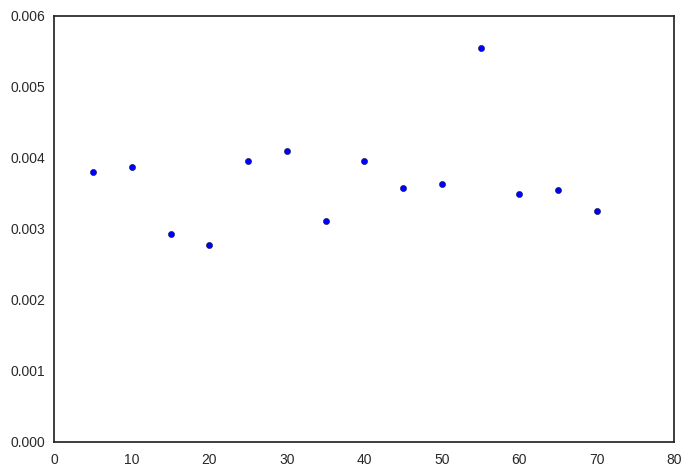

In [43]:
results_df = pd.DataFrame()

x = []
y = []
for key, value in results_dict.items():

    print key[0], np.median(value)
    x += [key[0]]
    y += [np.median(value)]

plt.scatter(np.array(x), np.array(y))
#sns.tsplot(data = y, err_style="ci_bars")


plt.ylim(0, 0.006)

In [193]:
print np.mean(av_sum_sqrs_list)
print np.median(av_sum_sqrs_list)

0.00147455846433
0.00129261569644


In [184]:
inds = np.triu_indices_from(av_corr_mat_B, k=1)
print av_corr_mat_B.shape
x = av_corr_mat_A[inds]
y = av_corr_mat_B[inds]
res = y - x
res_sq = res**2
av_sum_sqrs = np.sum(res_sq)/len(x)
print av_sum_sqrs

(116, 116)
0.00116388361694


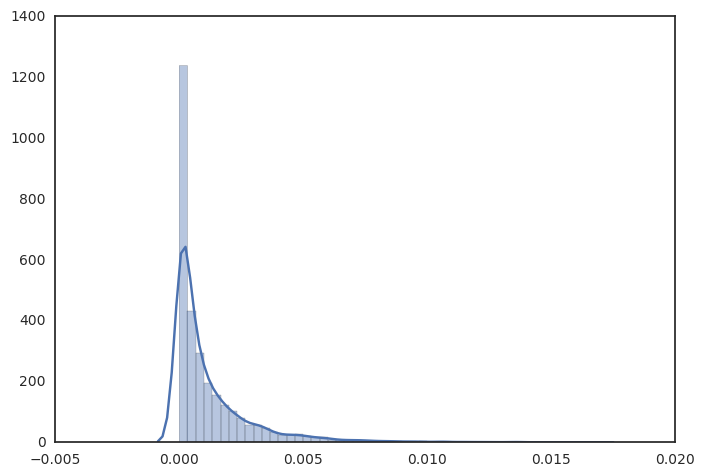

In [183]:
sns.distplot(res_sq)

In [ ]:
x = np.triu_indices

In [162]:
print np.diagonal(x.reshape(116, 116))

res = y - x

x[res==0].shape

res.shape
#res_reshape = res.reshape((116, 116))

#plt.imshow(res_reshape)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


(13456,)

In [96]:
np.triu(av_corr_mat_A, k=1)[:100]

(100, 116)

In [159]:
116*115/2

6670

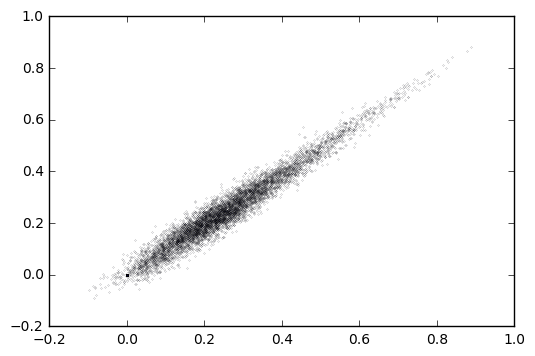

In [98]:
plt.scatter(np.triu(av_corr_mat_A, k=1).reshape(-1), np.triu(av_corr_mat_B, k=1).reshape(-1), s=0.01)

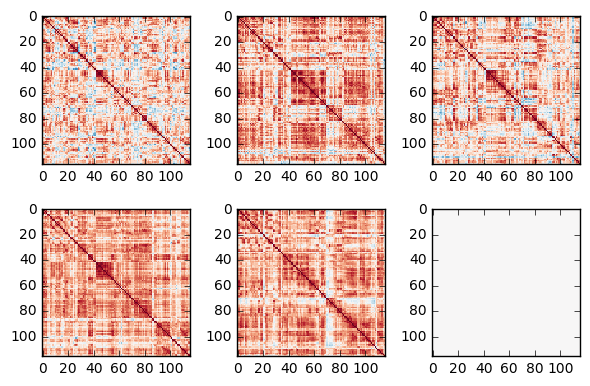

In [71]:
fig, ax_list = plt.subplots(2,3)

for i, ax in enumerate(ax_list.reshape(-1)):
    ax.imshow(all_corr_mat[:, :, i], interpolation='none', vmin=-1, vmax=1, cmap='RdBu_r')

plt.tight_layout()
plt.show()

In [48]:
corr_df = pd.read_table('../DATA/test_file.1D')

corr_df.describe()
#plt.imshow(corr_df.corr(), interpolation='nearest')

IOError: File ../DATA/test_file.1D does not exist

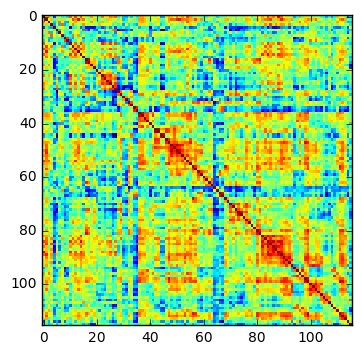

In [43]:
plt.imshow(corr_df.corr(), interpolation='none')

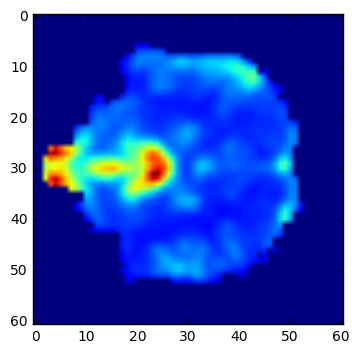

In [33]:
img = nib.load('DATA/test_file.nii.gz')
d = img.get_data()
plt.imshow(d[:, 30, :])